In [27]:
from algorithms import *
import msprime
import argparse
import numpy as np
import matplotlib.pyplot as plt


In [28]:
def verify_hundson_simulate(n_samples, sequence_length, 
                            recombination_rate, num_replicates):
    print('Py version:')
    parser = argparse.ArgumentParser()
    add_simulator_arguments(parser)
    args = parser.parse_args("")

    args.recombination_rate = recombination_rate
    args.sequence_length = sequence_length
    args.sample_size = n_samples
    args.num_replicates = num_replicates
    args.model = 'hudson'

    ts = run_simulate(args)
    print(ts.draw_text())

    print('C version:')
    ms_ts = msprime.sim_ancestry(
        samples=10,
        recombination_rate=0,
        sequence_length=1.0)
    print(ms_ts.draw_text())

In [29]:
def verify_single_sweep_simulate(n_samples, sequence_length, 
                                 recombination_rate, num_replicates, 
                                 population_size, s, dt):
    print('Py version:')
    parser = argparse.ArgumentParser()
    add_simulator_arguments(parser)
    args = parser.parse_args("")

    args.recombination_rate = recombination_rate
    args.sequence_length = sequence_length
    args.population_sizes = [population_size]
    args.sample_size = n_samples
    args.num_replicates = num_replicates
    args.time_slice = dt

    start_frequency = 1.0 / (2 * population_size)
    end_frequency = 1.0 - (1.0 / (2 * population_size))
    args.trajectory = [start_frequency, end_frequency, s]
    args.model = 'single_sweep'
    ts = run_simulate(args)
    print(ts.draw_text())
    
    print('C version:')
    # define hard sweep model
    sweep_model = msprime.SweepGenicSelection(
        position=sequence_length / 2,  # middle of chrom
        start_frequency=start_frequency,
        end_frequency=end_frequency,
        s=s,
        dt=dt,
    )

    reps = msprime.sim_ancestry(
        n_samples,
        model=sweep_model,
        recombination_rate=recombination_rate,
        population_size=population_size,
        sequence_length=sequence_length,
        num_replicates=num_replicates,
    )
    ts = next(reps, None)
    print(ts.draw_text())

In [30]:
def verify_single_sweep_diversity(n_samples, sequence_length, 
                                 recombination_rate, num_replicates, 
                                 population_size, s, dt):
    print('Py version:')
    parser = argparse.ArgumentParser()
    add_simulator_arguments(parser)
    args = parser.parse_args("")

    args.recombination_rate = recombination_rate
    args.sequence_length = sequence_length
    args.population_sizes = [population_size]
    args.sample_size = n_samples
    args.num_replicates = num_replicates
    args.time_slice = dt

    start_frequency = 1.0 / (2 * population_size)
    end_frequency = 1.0 - (1.0 / (2 * population_size))
    args.trajectory = [start_frequency, end_frequency, s]
    args.model = 'single_sweep'
    
    wins = np.linspace(0, args.sequence_length, 21)
    mids = (wins[1:] + wins[:-1]) / 2
    diversity = np.zeros((args.num_replicates, mids.shape[0]))
    
    for i in range(num_replicates):
        print(i)
        ts = run_simulate(args)
        diversity[i] = ts.diversity(windows=wins, mode="branch")

    plt.plot(mids, diversity.mean(axis=0), label="Simulations")
    plt.axhline(4 * args.population_sizes[0], linestyle=":", label=r'Neutral expectation')
    plt.ylabel(r'Branch $\pi$')
    plt.xlabel('Position (bp)')
    plt.legend();
    plt.savefig('sweep_diversity_Py_version.png');
   
    print('C version:')
    # define hard sweep model
    sweep_model = msprime.SweepGenicSelection(
        position=sequence_length / 2,  # middle of chrom
        start_frequency=start_frequency,
        end_frequency=end_frequency,
        s=s,
        dt=dt,
    )

    reps = msprime.sim_ancestry(
        n_samples,
        model=sweep_model,
        recombination_rate=recombination_rate,
        population_size=population_size,
        sequence_length=sequence_length,
        num_replicates=num_replicates,
    )
    
    wins = np.linspace(0, args.sequence_length, 21)
    mids = (wins[1:] + wins[:-1]) / 2
    diversity = np.zeros((args.num_replicates, mids.shape[0]))

    for j, ts in enumerate(reps):
        diversity[j] = ts.diversity(windows=wins, mode="branch")

    plt.plot(mids, diversity.mean(axis=0), label="Simulations")
    plt.axhline(4 * args.population_sizes[0], linestyle=":", label=r'Neutral expectation')
    plt.ylabel(r'Branch $\pi$')
    plt.xlabel('Position (bp)')
    plt.legend();
    plt.savefig('sweep_diversity_C_version.png');


Py version:
0


2023-08-08 11:03:30,901 [29149] INFO     root: Sweep time=123.154000 remain=0 nodes=19 edges=16


Population  0
	start_size =  1000.0
	growth_rate =  0
	Ancestors:  2
	Label =  0
		[0.0, 1000000.0: 0]
		[0.0, 1000000.0: 1]
		[0.0, 1000000.0: 2]
		[0.0, 1000000.0: 3]
		[0.0, 1000000.0: 4]
		[0.0, 1000000.0: 5]
		[0.0, 1000000.0: 6]
		[0.0, 1000000.0: 7]
		[0.0, 1000000.0: 8]
		[0.0, 1000000.0: 9]
	Label =  1


2023-08-08 11:03:31,074 [29149] INFO     msprime.ancestry: Sampling 5 individuals with ploidy 2 in population 0 (name='pop_0') at time 0
2023-08-08 11:03:31,077 [29149] INFO     msprime.ancestry: Starting replicate 0
2023-08-08 11:03:31,078 [29149] INFO     msprime.ancestry: model[0] {'name': 'single-sweep', 'locus': 500000.0} started at time=0 nodes=10 edges=0
2023-08-08 11:03:31,078 [29149] INFO     msprime.ancestry: Running model {'name': 'single-sweep', 'locus': 500000.0} until max time: inf
2023-08-08 11:03:31,080 [29149] INFO     msprime.ancestry: Completed at time=77.812 nodes=19 edges=18


C version:


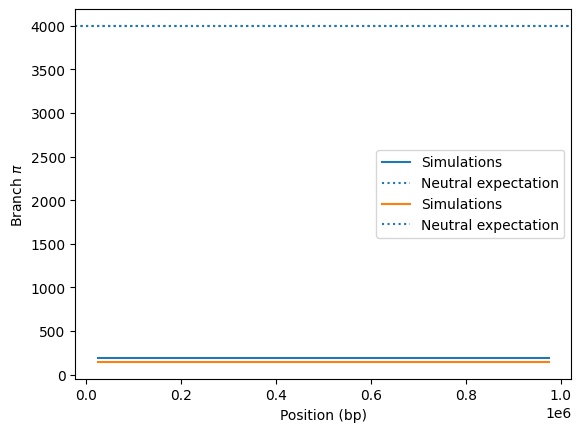

In [31]:
# Call your function
verify_single_sweep_diversity(n_samples=5, sequence_length=1e6, 

                             recombination_rate=0, num_replicates=1, 
                            population_size=1e3, s=0.25, dt=1e-6)
